In [1]:
from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
# from brax.training.agents.apg import train as apg
# from brax.training.agents.apg import networks as apg_networks
from brax.io import html, mjcf, model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
from jax import vmap
import jax.random
from jax import lax

In [2]:
import distutils.util
import os
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8" # 0.9 causes too much lag. 
from datetime import datetime
import functools

# Math
import jax.numpy as jp
import numpy as np
import jax
from jax import config # Analytical gradients work much better with double precision.
# config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', jax.lax.Precision.HIGH)
from brax import math

# Sim
import mujoco
import mujoco.mjx as mjx

# Brax
from brax import envs
from brax.base import Motion, Transform
from brax.io import mjcf
from brax.envs.base import PipelineEnv, State
from brax.mjx.pipeline import _reformat_contact
from brax.training.acme import running_statistics
from brax.io import model

# Algorithms
# from brax.training.agents.apg import train as apg
# from brax.training.agents.apg import networks as apg_networks
from brax.training.agents.ppo import train as ppo

# Supporting
from etils import epath
import mediapy as media
import matplotlib.pyplot as plt
from ml_collections import config_dict
from typing import Any, Dict



In [4]:
from utils.SimpleConverter import SimpleConverter
from agent_mimic_env.agent_template import HumanoidTemplate
from agent_mimic_env.agent_eval_template import HumanoidEvalTemplate
from agent_mimic_env.agent_training_template import HumanoidTrainTemplate
from agent_mimic_env.agent_test_apg import HumanoidAPGTest
from utils.util_data import *
from copy import deepcopy

In [5]:
import agent_mimic_env
from agent_mimic_env import register_mimic_env

In [6]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [7]:
import yaml
from box import Box
# Path to your YAML file
yaml_file_path = 'config_params/punch.yaml'
# Load the YAML file
with open(yaml_file_path, 'r') as file:
    args = Box(yaml.safe_load(file))

In [8]:
args

Box({'num_envs': 256, 'num_eval_envs': 32, 'lr': 0.0003, 'max_it': 1000, 'max_grad_norm': 0.4, 'seed': 0, 'system_config': 'humanoid', 'demo_replay_mode': 'threshold', 'threshold': 0.4, 'normalize_observations': True, 'cycle_len': 130, 'ep_len': 65, 'ep_len_eval': 54, 'use_lr_scheduler': True, 'reward_scaling': 0.02, 'rot_weight': 0.5, 'vel_weight': 0.3, 'ang_weight': 0.01, 'deep_mimic_reward_weights': {'w_p': 0.3, 'w_v': 0.1, 'w_e': 0.5, 'w_c': 0.1}, 'deep_mimic_weights_factors': {'w_pose': 2, 'w_angular': 0.005, 'w_efector': 5, 'w_com': 100}, 'model': 'models/final_humanoid.xml', 'ref': 'motions/humanoid3d_punch_duplicated.txt'})

In [9]:
from agent_mimic_env.pds_controllers_agents import feedback_pd_controller, stable_pd_controller_action

In [10]:
def generate_env_apg_train(trajectory,model_path,env_name_apg,args):
    
    #model_path = 'anybotics_anymal_c/scene_mjx.xml'
    #model_path = 'models/humanoidMjx.xml'
    model_path = 'models/other_humanoid2.xml'
    
    env_kwargs = dict(referece_data=trajectory,model_path=model_path,args=args) 
    
    env = envs.get_environment(env_name_apg,**env_kwargs)
    return env
    

In [11]:
trajectory = SimpleConverter(args.ref)
trajectory.load_mocap()
    #model_path = 'models/final_humanoid.xml'
model_path = args.model
envs.register_environment('humanoidApgTest',HumanoidAPGTest)
env_name_apg = 'humanoidApgTest'

env_apg = generate_env_apg_train(trajectory,model_path,env_name_apg,args)
env_eval = generate_env_apg_train(trajectory,model_path,env_name_apg,args)



#env_replay,env_eval, env,env_apg=register_mimic_env(args)

#for the eval here we run the trained policy
# jit_reset = jax.jit(env_eval.reset)
# jit_step = jax.jit(env_eval.step)

# env_eval.set_pd_callback(stable_pd_controller_action)

# env.set_pd_callback(stable_pd_controller_action)
#env_apg.set_pd_callback(stable_pd_controller_action)

In [12]:
# xd = jp.asarray(trajectory.data_pos)
# xd = xd[:,:19]
# xd.shape

In [13]:
# episode_len = env_apg.cycle_len
# print(episode_len)


In [14]:
from APGBRAX import train as apg
from APGBRAX import networks as apg_networks

# from brax.training.agents.apg import train as apg
# from brax.training.agents.apg import networks as apg_networks

In [15]:
make_networks_factory = functools.partial(
    apg_networks.make_apg_networks,
    hidden_layer_sizes=(512, 256)
)

epochs = 499


train_fn = functools.partial(apg.train,
                             episode_length=130-1,
                             policy_updates=epochs,
                             horizon_length=32,
                             num_envs=64,
                             learning_rate=1.5e-4,
                             schedule_decay=0.995,
                             num_eval_envs=64,
                             num_evals=10 + 1,
                             use_float64=True,
                             normalize_observations=True,
                             network_factory=make_networks_factory)




before metrics


/tmp/ipykernel_1693/4271990847.py:15: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, it* 1.25])


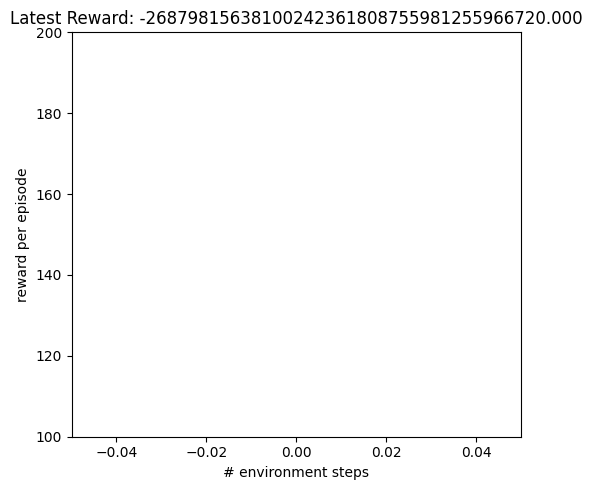

after metrics
after scramble time
it 0
before epoch
reached the minibatch step:{} 1
loss
after f
env step
Actions: {} Traced<ShapedArray(float64[64,28])>with<DynamicJaxprTrace(level=4/1)>
New state obs: {} Traced<ShapedArray(float64[64,72])>with<DynamicJaxprTrace(level=4/1)>
after loss
after the minibatch_step
jax trainng epoch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sss

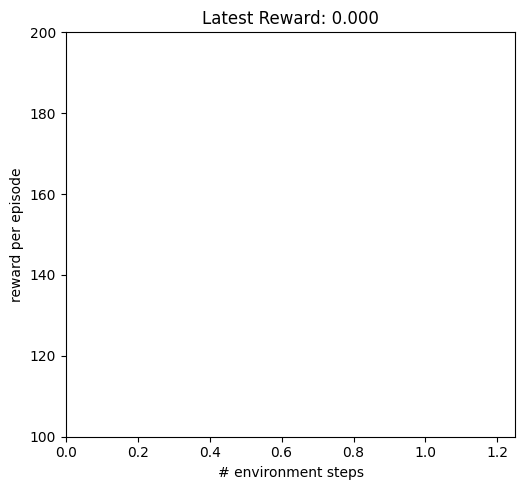

it 1
before epoch
jax trainng epoch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1


E0610 23:28:31.720388    1693 pjrt_stream_executor_client.cc:2826] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/home/u

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/asyncio/events.py", line 84, in _run
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_1693/4271990847.py", line 28, in <module>
  File "/home/user/workspace/RLPhysics/Physics-Based-RL/APGBRAX/train.py", line 396, in train
  File "/home/user/workspace/RLPhysics/Physics-Based-RL/APGBRAX/train.py", line 308, in training_epoch_with_timing
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/jax/_src/api.py", line 1761, in cache_miss
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/jax/_src/profiler.py", line 335, in wrapper
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py", line 1177, in __call__
  File "/home/user/anaconda3/envs/newBrax/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py", line 2482, in _wrapped_callback
KeyboardInterrupt: 

In [16]:
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

def progress(it, metrics):
  times.append(datetime.now())
  x_data.append(it)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])
  #y_pose_error.append(metrics['eval/episode_pose_error'])  # capture pose error
  
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1) 
  plt.xlim([0, it* 1.25])
  plt.ylim([100, 200])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'Latest Reward: {y_data[-1]:.3f}')
  plt.plot(x_data, y_data, '-o')
  
  plt.tight_layout()
  plt.show()
  
  

make_inference_fn, params, _= train_fn(environment=env_apg,
                                       progress_fn=progress,
                                       eval_env=env_eval)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')